In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sys

In [162]:
network = 'mirdip_complete'

In [163]:
pic_path = '../local/pictures/'

In [164]:
def remove_duplicates(df):
	df_cp = df.copy()
	"Remove duplicate rows based on 'miRNA_1_name' and 'miRNA_2_name' regardless of order."
	df_cp['pair'] = df_cp.apply(lambda x: tuple(sorted([x['miRNA_1_name'], x['miRNA_2_name']])), axis=1)
	unique_df = df_cp.drop_duplicates(subset='pair').drop(columns='pair')
	return unique_df


def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	df1_cp = df1.copy()
	df2_cp = df2.copy()
	for _, row in df2_cp.iterrows():
		mirna1 = row['miRNA_1_name']
		mirna2 = row['miRNA_2_name']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1_cp[~df1_cp.apply(lambda row: tuple(sorted([row['miRNA_1_name'], row['miRNA_2_name']])) in mirna_pairs, axis=1)]

	return filtered_df

___________________________________________

## Literature-based SSD-derived and WGD-derived miRNA pair

In [165]:
ensembl_paralogmirna_path = './sd.ensembl_paralogmirna.tsv'
mirgenedb_paralogmirna_path = './sd.mgdb_paralogmirna.tsv'
mirgenedb_ohnomirna_path = './sd.mgdb_ohnomirna.tsv'

df_ensembl_p = pd.read_csv(ensembl_paralogmirna_path, sep='\t')
df_mirgenedb_p = pd.read_csv(mirgenedb_paralogmirna_path, sep='\t')
df_mirgenedb_o = pd.read_csv(mirgenedb_ohnomirna_path, sep='\t')

print("Original data sizes:", file=sys.stderr)
print(f"Ensembl Paralog miRNA: {df_ensembl_p.shape[0]}", file=sys.stderr)
print(f"miRGeneDB Paralog miRNA: {df_mirgenedb_p.shape[0]}", file=sys.stderr)
print(f"miRGeneDB Ohno miRNA: {df_mirgenedb_o.shape[0]}", file=sys.stderr)

# remove rows where the third column (Sorensen-Dice similarity coefficient) is not a number
df_ensembl_p = df_ensembl_p[pd.to_numeric(df_ensembl_p.iloc[:, 2], errors='coerce').notnull()]
df_mirgenedb_p = df_mirgenedb_p[pd.to_numeric(df_mirgenedb_p.iloc[:, 2], errors='coerce').notnull()]
df_mirgenedb_o = df_mirgenedb_o[pd.to_numeric(df_mirgenedb_o.iloc[:, 2], errors='coerce').notnull()]

print(150*"-", file=sys.stderr)
print(f"Data sizes after removing non-numeric Sorensen-Dice similarity coefficients (meaning not both miRNAs are in the network):", file=sys.stderr)
print(f"Ensembl Paralog miRNA: {df_ensembl_p.shape[0]}", file=sys.stderr)
print(f"miRGeneDB Paralog miRNA: {df_mirgenedb_p.shape[0]}", file=sys.stderr)
print(f"miRGeneDB Ohno miRNA: {df_mirgenedb_o.shape[0]}", file=sys.stderr)

col_names = ['miRNA_1_name', 'miRNA_2_name', f'{network}_sd_similarity', 'Error_cause']
df_ensembl_p.columns = col_names
df_mirgenedb_p.columns = col_names
df_mirgenedb_o.columns = col_names

# remove duplicates
df_ensembl_p = remove_duplicates(df_ensembl_p)
df_mirgenedb_p = remove_duplicates(df_mirgenedb_p)
df_mirgenedb_o = remove_duplicates(df_mirgenedb_o)

# remove ohnologs from paralog miRNAs
df_ensembl_p = remove_mirna_pairs(df_ensembl_p, df_mirgenedb_o)
df_mirgenedb_p = remove_mirna_pairs(df_mirgenedb_p, df_mirgenedb_o)

# drop the 'Error_cause' column
df_ensembl_p = df_ensembl_p.drop(columns=['Error_cause'])
df_mirgenedb_p = df_mirgenedb_p.drop(columns=['Error_cause'])
df_mirgenedb_o = df_mirgenedb_o.drop(columns=['Error_cause'])

Original data sizes:
Ensembl Paralog miRNA: 2149
miRGeneDB Paralog miRNA: 2654
miRGeneDB Ohno miRNA: 127
------------------------------------------------------------------------------------------------------------------------------------------------------
Data sizes after removing non-numeric Sorensen-Dice similarity coefficients (meaning not both miRNAs are in the network):
Ensembl Paralog miRNA: 756
miRGeneDB Paralog miRNA: 1405
miRGeneDB Ohno miRNA: 126


_______________________________________

## Putative intragenic SSD and WGD miRNA pairs

In [166]:
putative_intragenic_ohnomirna_path = '../../OhnomiRNAs/dataset/6_ReciprocalBestHits/ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_wgd.tsv'
putative_intragenic_paralogmirna_path = '../../OhnomiRNAs/dataset/6_ReciprocalBestHits/ohnomirna_paralogmirna.ssdmirna_wgdmirna_ensembl_check.7mer_s5_align_scores.tarbase_flag.strand_check.tarbase_sd.mirdip_top_sd.mirdip_complete_sd.rbh_ssd.tsv'

df_putative_intragenic_p = pd.read_csv(putative_intragenic_paralogmirna_path, sep='\t')
df_putative_intragenic_o = pd.read_csv(putative_intragenic_ohnomirna_path, sep='\t')

df_putative_intragenic_o = df_putative_intragenic_o[df_putative_intragenic_o['#_host_gene_1_ID'] != df_putative_intragenic_o['host_gene_2_ID']]
df_putative_intragenic_p = df_putative_intragenic_p[df_putative_intragenic_p['#_host_gene_1_ID'] != df_putative_intragenic_p['host_gene_2_ID']]

df_putative_intragenic_o = df_putative_intragenic_o[df_putative_intragenic_o['miRNA_1_ID'] != df_putative_intragenic_o['miRNA_2_ID']]
df_putative_intragenic_p = df_putative_intragenic_p[df_putative_intragenic_p['miRNA_1_ID'] != df_putative_intragenic_p['miRNA_2_ID']]

print("Original size of putative intragenic datasets:", file=sys.stderr)
print(f"Putative Intragenic Paralog miRNA: {df_putative_intragenic_p.shape[0]}", file=sys.stderr)
print(f"Putative Intragenic OhnomiRNA: {df_putative_intragenic_o.shape[0]}", file=sys.stderr)


Original size of putative intragenic datasets:
Putative Intragenic Paralog miRNA: 301
Putative Intragenic OhnomiRNA: 64


In [167]:
df_putative_intragenic_p_ensemblConfirmed = df_putative_intragenic_p[df_putative_intragenic_p["miRNA_pair_LCA"] != "Ensembl_not_verified"]
df_putative_intragenic_o_ensemblConfirmed = df_putative_intragenic_o[df_putative_intragenic_o["miRNA_pair_LCA"] != "Ensembl_not_verified"]

print(100*"-", file=sys.stderr)
print("Size of putative intragenic datasets:", file=sys.stderr)
print(f"Putative Intragenic Paralog miRNA: {df_putative_intragenic_p.shape[0]}", file=sys.stderr)
print(f"Putative Intragenic OhnomiRNA: {df_putative_intragenic_o.shape[0]}", file=sys.stderr)
print(100*"-", file=sys.stderr)
print("Size of putative intragenic datasets after Ensembl duplicated-miRNAs-only filter:", file=sys.stderr)
print(f"Putative Intragenic Paralog miRNA: {df_putative_intragenic_p_ensemblConfirmed.shape[0]}", file=sys.stderr)
print(f"Putative Intragenic OhnomiRNA: {df_putative_intragenic_o_ensemblConfirmed.shape[0]}", file=sys.stderr)
print(100*"-", file=sys.stderr)


----------------------------------------------------------------------------------------------------
Size of putative intragenic datasets:
Putative Intragenic Paralog miRNA: 301
Putative Intragenic OhnomiRNA: 64
----------------------------------------------------------------------------------------------------
Size of putative intragenic datasets after Ensembl duplicated-miRNAs-only filter:
Putative Intragenic Paralog miRNA: 10
Putative Intragenic OhnomiRNA: 17
----------------------------------------------------------------------------------------------------


In [168]:
cols_to_keep = ['miRNA_1_name', 'miRNA_2_name', f'{network}_sd_similarity']
df_putative_intragenic_p_red = df_putative_intragenic_o[cols_to_keep]
df_putative_intragenic_o_red = df_putative_intragenic_p[cols_to_keep]
df_putative_intragenic_p_preEnsFilter_red = df_putative_intragenic_p_ensemblConfirmed[cols_to_keep]
df_putative_intragenic_o_preEnsFilter_red = df_putative_intragenic_o_ensemblConfirmed[cols_to_keep]

# remove duplicates
df_putative_intragenic_p_red = remove_duplicates(df_putative_intragenic_p_red)
df_putative_intragenic_o_red = remove_duplicates(df_putative_intragenic_o_red)
df_putative_intragenic_p_preEnsFilter_red = remove_duplicates(df_putative_intragenic_p_preEnsFilter_red)
df_putative_intragenic_o_preEnsFilter_red = remove_duplicates(df_putative_intragenic_o_preEnsFilter_red)

# drop NaN in Sorensen-Dice similarity columns
df_putative_intragenic_p_red = df_putative_intragenic_p_red.dropna(subset=[f'{network}_sd_similarity'])
df_putative_intragenic_o_red = df_putative_intragenic_o_red.dropna(subset=[f'{network}_sd_similarity'])
df_putative_intragenic_p_preEnsFilter_red = df_putative_intragenic_p_preEnsFilter_red.dropna(subset=[f'{network}_sd_similarity'])
df_putative_intragenic_o_preEnsFilter_red = df_putative_intragenic_o_preEnsFilter_red.dropna(subset=[f'{network}_sd_similarity'])

print(100*"-", file=sys.stderr)
print("Size of putative intragenic datasets after removing NaN in Sorensen-Dice similarity columns:", file=sys.stderr)
print(f"Putative Intragenic Paralog miRNA: {df_putative_intragenic_p_red.shape[0]}", file=sys.stderr)
print(f"Putative Intragenic OhnomiRNA: {df_putative_intragenic_o_red.shape[0]}", file=sys.stderr)
print(100*"-", file=sys.stderr)
print("Size of putative intragenic datasets after removing NaN in Sorensen-Dice similarity columns (pre-Ensembl filter):", file=sys.stderr)
print(f"Putative Intragenic Paralog miRNA: {df_putative_intragenic_p_preEnsFilter_red.shape[0]}", file=sys.stderr)
print(f"Putative Intragenic OhnomiRNA: {df_putative_intragenic_o_preEnsFilter_red.shape[0]}", file=sys.stderr)
print(100*"-", file=sys.stderr)


----------------------------------------------------------------------------------------------------
Size of putative intragenic datasets after removing NaN in Sorensen-Dice similarity columns:
Putative Intragenic Paralog miRNA: 63
Putative Intragenic OhnomiRNA: 295
----------------------------------------------------------------------------------------------------
Size of putative intragenic datasets after removing NaN in Sorensen-Dice similarity columns (pre-Ensembl filter):
Putative Intragenic Paralog miRNA: 10
Putative Intragenic OhnomiRNA: 17
----------------------------------------------------------------------------------------------------


____________________

# Plots

#### Putative intragenic pairs without filters

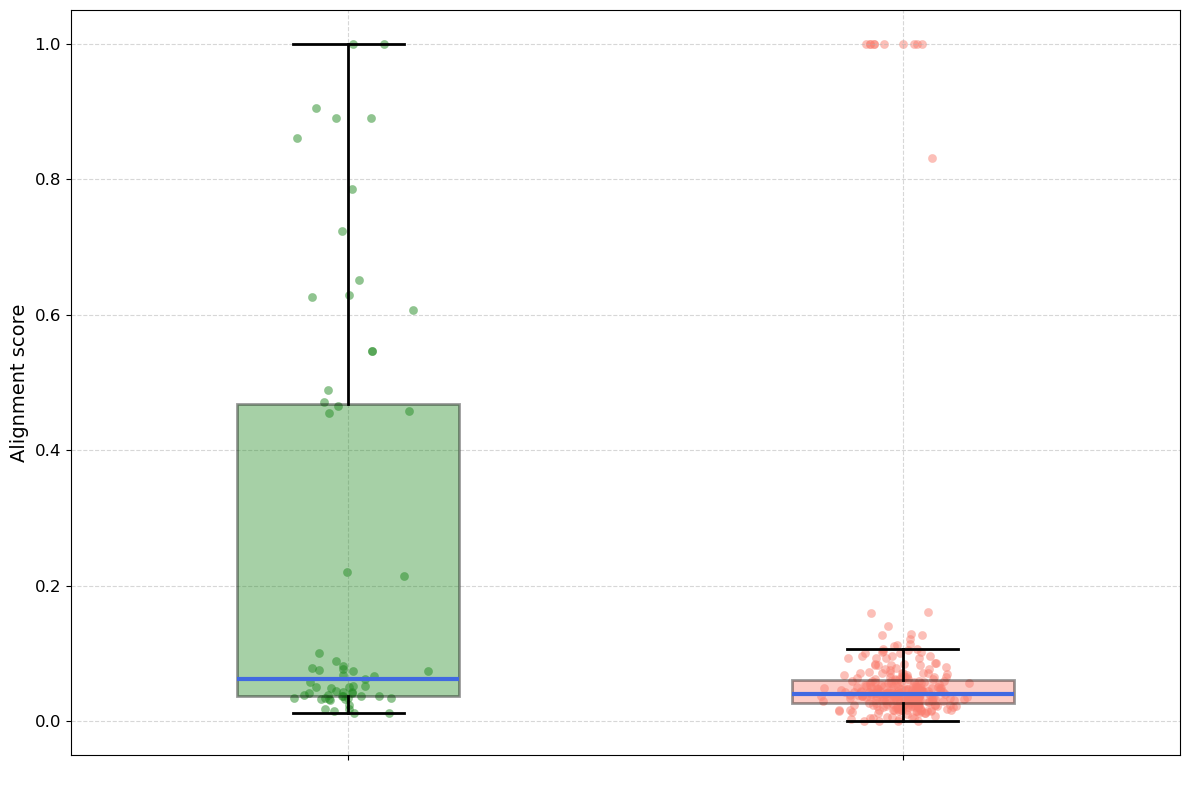

In [169]:
data = [df.iloc[:, 2].dropna().values for df in [df_putative_intragenic_p_red, df_putative_intragenic_o_red]]
positions = [0, 1]
colors = ['forestgreen', 'salmon']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('royalblue')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}{network}_putative_intragenic_target_similarity_boxplot.jpg', dpi=300)	
plt.show()

In [170]:
# test the significance of the difference between the two distributions using kolmogorov-smirnov test
ks_statistic, p_value = stats.ks_2samp(data[0], data[1])
print(f'Kolmogorov-Smirnov test statistic: {ks_statistic}, p-value: {p_value}', file=sys.stderr)

Kolmogorov-Smirnov test statistic: 0.296045197740113, p-value: 0.00015808144083533516


### MirGeneDB WGD vs. Mirgenedb SSD

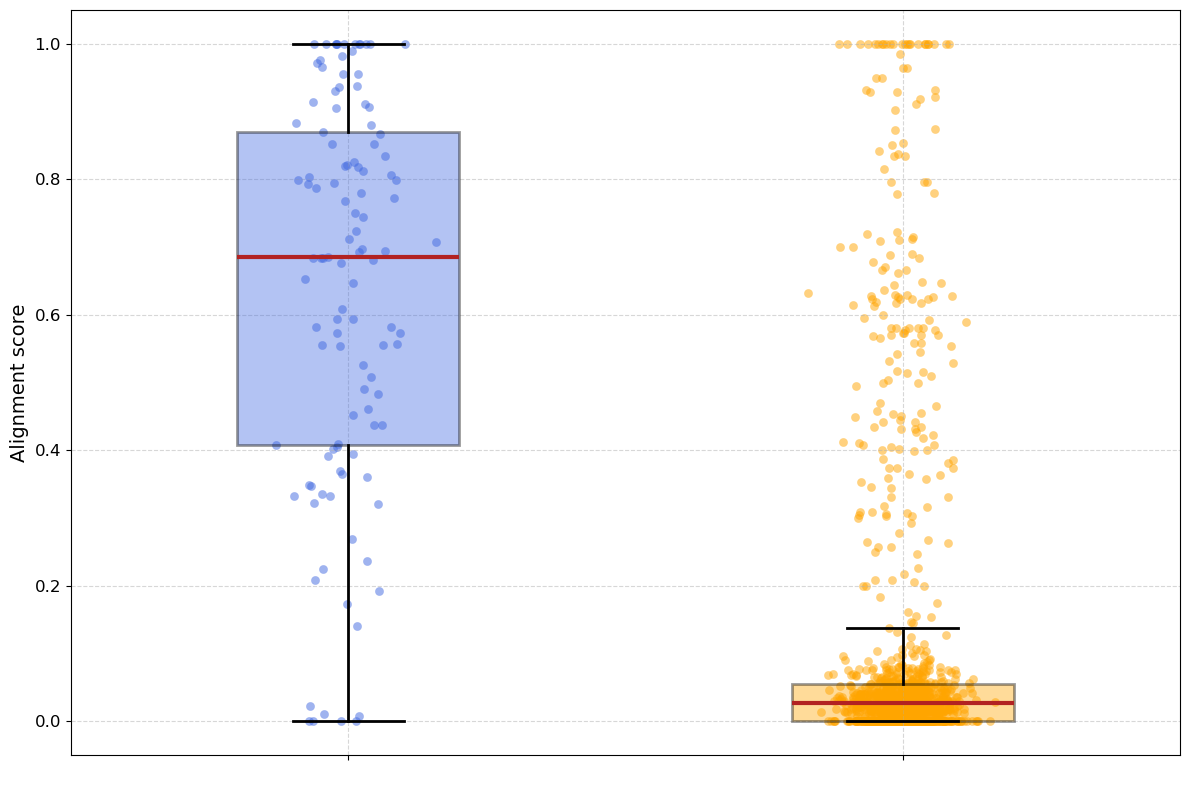

In [171]:
data = [df.iloc[:, 2].dropna().values for df in [df_mirgenedb_o, df_mirgenedb_p]]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}{network}_true_duplicates_mgdb_target_similarity_boxplot.jpg', dpi=300)
plt.show()

In [172]:
ks_statistic, p_value = stats.ks_2samp(data[0], data[1])
print(f'Kolmogorov-Smirnov test statistic: {ks_statistic}, p-value: {p_value}', file=sys.stderr)

Kolmogorov-Smirnov test statistic: 0.7846305953781776, p-value: 7.569710338161384e-67


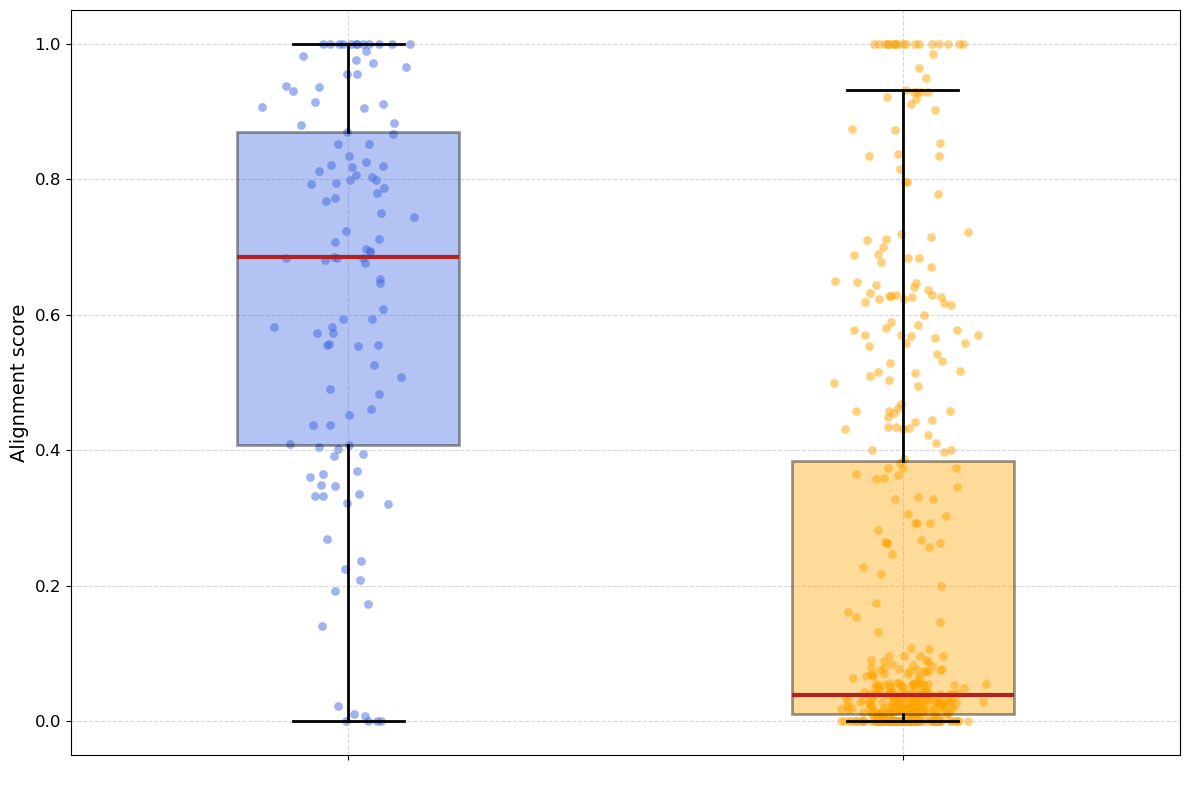

In [173]:
data = [df.iloc[:, 2].dropna().values for df in [df_mirgenedb_o, df_ensembl_p]]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
				  #notch=True,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['WGD', 'SSD'][i])

plt.ylabel('Alignment score', fontsize=14)
plt.xticks(positions, [' ', ' '], fontsize=100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'{pic_path}{network}_true_duplicates_EnsemblSSD_target_similarity_boxplot.jpg', dpi=300)
plt.show()

In [174]:
ks_statistic, p_value = stats.ks_2samp(data[0], data[1])
print(f'Kolmogorov-Smirnov test statistic: {ks_statistic}, p-value: {p_value}', file=sys.stderr)

Kolmogorov-Smirnov test statistic: 0.6171739764660119, p-value: 3.4431566653174337e-33
